In [1]:
# ===== 1. Load data =====
import pandas as pd
data = pd.read_csv("./csv_output_merged/deepseek-v2_236b_promotion.csv")
print("✅ Columns:", data.columns.tolist())

✅ Columns: ['sample_id', 'ad_type', 'gender', 'age', 'education', 'occupation', 'marital_status', 'monthly_income', 'region', 'BFI_11', 'BFI_12', 'BFI_13', 'BFI_21', 'BFI_22', 'BFI_23', 'BFI_31', 'BFI_32', 'BFI_33', 'BFI_41', 'BFI_42', 'BFI_43', 'BFI_51', 'BFI_52', 'BFI_53', 'ad_att_1', 'ad_att_2', 'ad_att_3', 'ad_att_4', 'intent_1', 'intent_2', 'intent_3']


In [2]:
import logging
import numpy as np
from semopy import Model, semplot, calc_stats
from scipy.stats import norm
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")
logging.getLogger("semopy").setLevel(logging.ERROR)

Path("sem_outputs").mkdir(exist_ok=True)

# ===== 2. Define SEM model (measurement + structural) =====
sem_model = """
F1 =~ BFI_11 + BFI_12 + BFI_13
F2 =~ BFI_21 + BFI_22 + BFI_23
F3 =~ BFI_31 + BFI_32 + BFI_33
F4 =~ BFI_41 + BFI_42 + BFI_43
F5 =~ BFI_51 + BFI_52 + BFI_53
F6 =~ ad_att_1 + ad_att_2 + ad_att_3 + ad_att_4
F7 =~ intent_1 + intent_2 + intent_3
F7 ~ F6
F6 ~ F1 + F2 + F3 + F4 + F5
"""

# ===== 3. Fit model =====
model = Model(sem_model)
model.fit(data)
print("✅ Model fitting completed")

# ===== 4. Plot (standardized coefficients) =====
semplot(model, "./sem_outputs/sem_model_standardized.dot", plot_covs=True, plot_ests=True, std_ests=True)
semplot(model, "./sem_outputs/sem_model_standardized.png", plot_covs=True, plot_ests=True, std_ests=True)
print("✅ Standardized coefficient plot saved to ./sem_outputs/sem_model_standardized.png")

# ===== 5. Export parameter estimates (raw + standardized) =====
estimates_raw = model.inspect()
estimates_std = model.inspect(std_est=True)

# ===== 6. Merge standard errors and p-values into standardized results =====
common_cols = ['lval', 'op', 'rval']
if all(c in estimates_raw.columns for c in ['SE', 'z-value', 'p-value']):
    estimates_std = estimates_std.merge(
        estimates_raw[common_cols + ['SE', 'z-value', 'p-value']],
        on=common_cols,
        how='left'
    )

estimates_raw.to_csv("./sem_outputs/sem_estimates_raw.csv", index=False, encoding="utf-8-sig")
estimates_std.to_csv("./sem_outputs/sem_estimates_standardized_full.csv", index=False, encoding="utf-8-sig")
print("✅ Saved parameter estimates (raw & standardized)")


# ===== 7. Label mapping =====
factor_labels = {
    "F1": "Extraversion",
    "F2": "Agreeableness",
    "F3": "Conscientiousness",
    "F4": "Neuroticism",
    "F5": "Openness",
    "F6": "Ad Attitude",
    "F7": "Purchase Intention"
}

def replace_labels(path: str) -> str:
    for k, v in factor_labels.items():
        path = path.replace(k, v)
    return path


# ===== 8. Effect decomposition (dynamic monitoring + NaN filtering + stats) =====
def sem_effects_dynamic(model, data, sem_model, estimates, n_boot=500, seed=42, monitor_step=10):
    np.random.seed(seed)

    # ---- Direct effects ----
    df_direct = estimates[estimates["op"] == "~"].copy()
    df_direct["Path"] = df_direct["rval"] + " → " + df_direct["lval"]
    df_direct["Path"] = df_direct["Path"].apply(replace_labels)
    cols = ["Path"] + [c for c in df_direct.columns if c not in ["lval","rval","Path"]]
    df_direct = df_direct[cols]

    # ---- Bootstrapping ----
    boot_indirect = []
    results = []
    nan_count = 0   # Count of dropped NaN samples

    for i in range(1, n_boot + 1):
        sample = data.sample(frac=1, replace=True)
        try:
            m = Model(sem_model)
            m.fit(sample)
            est = m.inspect(std_est=True)
            coeffs = {(r.lval, r.rval): r["Est. Std"] for _, r in est.iterrows() if r.op == "~"}

            for trait in ["F1", "F2", "F3", "F4", "F5"]:
                if (("F6", trait) in coeffs) and (("F7", "F6") in coeffs):
                    ind = coeffs[("F6", trait)] * coeffs[("F7", "F6")]
                    tot = ind + coeffs.get(("F7", trait), 0.0)

                    if np.isnan(ind) or np.isnan(tot):
                        nan_count += 1
                        continue  # drop NaN
                    path = replace_labels(trait + " → F6 → F7")
                    boot_indirect.append((path, ind, tot))
        except Exception:
            continue

        # === Dynamic monitoring ===
        if i % monitor_step == 0:
            boot_df = pd.DataFrame(boot_indirect, columns=["Path", "Indirect", "Total"])
            ci = boot_df.groupby("Path").agg(
                N_samples=("Indirect", "count"),
                Indirect_mean=("Indirect", "mean"),
                Indirect_CI_low=("Indirect", lambda x: np.percentile(x, 2.5) if len(x) > 0 else np.nan),
                Indirect_CI_high=("Indirect", lambda x: np.percentile(x, 97.5) if len(x) > 0 else np.nan),
                Total_mean=("Total", "mean"),
                Total_CI_low=("Total", lambda x: np.percentile(x, 2.5) if len(x) > 0 else np.nan),
                Total_CI_high=("Total", lambda x: np.percentile(x, 97.5) if len(x) > 0 else np.nan),
            ).reset_index()

            print(f"\rIter {i}/{n_boot} | Dropped {nan_count} NaN samples", end="")

            results.append((i, ci.copy()))

    print(f"\n⚠️ Total dropped {nan_count} NaN samples")
    final_ci = results[-1][1] if results else pd.DataFrame()
    return df_direct, final_ci, results

# ===== 9. Run =====
df_direct, df_ci, monitor_results = sem_effects_dynamic(model, data, sem_model, estimates_std, n_boot=500, monitor_step=5)

# ===== 10. Save tables =====
df_direct.to_csv("./sem_outputs/sem_direct_effects.csv", index=False, encoding="utf-8-sig")
df_ci.to_csv("./sem_outputs/sem_indirect_total_effects.csv", index=False, encoding="utf-8-sig")

print("✅ Direct, Indirect, Total Effects saved to CSV.")

✅ Model fitting completed
✅ Standardized coefficient plot saved to ./sem_outputs/sem_model_standardized.png
✅ Saved parameter estimates (raw & standardized)
Iter 500/500 | Dropped 26 NaN samples
⚠️ Total dropped 26 NaN samples
✅ Direct, Indirect, Total Effects saved to CSV.


In [3]:
import re
from pathlib import Path

IN_DOT  = "./sem_outputs/sem_model_standardized.dot"
OUT_DOT = "./sem_outputs/sem_model_standardized.dot"

BFI_order = [
    "BFI_13","BFI_12","BFI_11",
    "BFI_23","BFI_22","BFI_21",
    "BFI_33","BFI_32","BFI_31",
    "BFI_43","BFI_42","BFI_41",
    "BFI_53","BFI_52","BFI_51",
]
F15  = ["F1","F2","F3","F4","F5"]
ADs  = ["ad_att_1","ad_att_2","ad_att_3","ad_att_4"]
INTS = ["intent_1","intent_2","intent_3"]

X_BFI, X_F15, X_F67, X_ADI = 100, 400, 700, 1000
Y_TOP, Y_STEP = 700, 44

def assign_col(names, x, start_idx=0):
    return {n: (x, Y_TOP - (start_idx+i)*Y_STEP) for i, n in enumerate(names)}

pos_map = {}
pos_map.update(assign_col(BFI_order, X_BFI))

def mean_y(names): 
    return sum(pos_map[n][1] for n in names)/len(names)

# The Y coordinate of F1–F5 is the mean of their indicators
pos_map["F1"] = (X_F15, mean_y(["BFI_13","BFI_12","BFI_11"]))
pos_map["F2"] = (X_F15, mean_y(["BFI_23","BFI_22","BFI_21"]))
pos_map["F3"] = (X_F15, mean_y(["BFI_33","BFI_32","BFI_31"]))
pos_map["F4"] = (X_F15, mean_y(["BFI_43","BFI_42","BFI_41"]))
pos_map["F5"] = (X_F15, mean_y(["BFI_53","BFI_52","BFI_51"]))

# Align F6/F7 with F2/F4
pos_map["F6"] = (X_F67, pos_map["F2"][1])  # F6 at the same level as F2
pos_map["F7"] = (X_F67, pos_map["F4"][1])  # F7 at the same level as F4

# ad_att arranged symmetrically around F6
gap_ad = 40
start_y_ad = pos_map["F6"][1] + (len(ADs)-1)/2 * gap_ad
for i, name in enumerate(ADs):
    pos_map[name] = (X_ADI, start_y_ad - i * gap_ad)

# intent arranged symmetrically around F7
gap_int = 40
start_y_int = pos_map["F7"][1] + (len(INTS)-1)/2 * gap_int
for i, name in enumerate(INTS):
    pos_map[name] = (X_ADI, start_y_int - i * gap_int)

ALL_TARGETS = set(pos_map.keys())

def rewrite_node_block(text, name, x, y):
    pat = re.compile(rf'^(\s*)({re.escape(name)})\s*\[\s*((?:.|\n)*?)\];',
                     flags=re.M | re.S)
    def _repl(m):
        indent, nm, attrs = m.group(1), m.group(2), m.group(3)
        attrs = re.sub(r',?\s*pos="[^"]*"', '', attrs)
        attrs = re.sub(r',?\s*pin=true', '', attrs)
        attrs = attrs.strip().rstrip(',')
        add   = f'pin=true, pos="{x:.1f},{y:.1f}!"'
        new_attrs = (attrs + ', ' + add) if attrs else add
        return f'{indent}{nm} [\n{new_attrs}\n{indent}];'
    return pat.sub(_repl, text, count=1)

def strip_edge_pos_lp(text, names):
    edge_begin = re.compile(r'^(\s*)([A-Za-z_]\w*)\s*->\s*([A-Za-z_]\w*)', flags=re.M)
    out, i = [], 0
    lines = text.splitlines(keepends=True)
    while i < len(lines):
        line = lines[i]
        m = edge_begin.match(line)
        if not m:
            out.append(line); i += 1; continue
        src_name, dst_name = m.group(2), m.group(3)
        block = [line]
        j = i + 1
        while j < len(lines) and not lines[j].strip().endswith(';'):
            block.append(lines[j]); j += 1
        if j < len(lines): block.append(lines[j])
        block_text = ''.join(block)
        if (src_name in names) or (dst_name in names):
            block_text = re.sub(r',?\s*pos="[^"]*"', '', block_text)
            block_text = re.sub(r',?\s*lp="[^"]*"',  '', block_text)
            block_text = re.sub(r',\s*\]', ']', block_text)
        out.append(block_text)
        i = j + 1
    return ''.join(out)

src = Path(IN_DOT).read_text(encoding="utf-8")
out_txt = src
for nm,(x,y) in pos_map.items():
    out_txt = rewrite_node_block(out_txt, nm, x, y)

out_txt = strip_edge_pos_lp(out_txt, ALL_TARGETS)

if "graph [" in out_txt and "layout=" not in out_txt:
    out_txt = out_txt.replace("graph [", "graph [layout=neato, ", 1)

Path(OUT_DOT).write_text(out_txt, encoding="utf-8")
print(f"✅ Written: {OUT_DOT}")
print(f'Render command: neato -n -Tpng "{OUT_DOT}" -o ./sem_outputs/sem_model_standardized_aligned.png')

✅ Written: ./sem_outputs/sem_model_standardized.dot
Render command: neato -n -Tpng "./sem_outputs/sem_model_standardized.dot" -o ./sem_outputs/sem_model_standardized_aligned.png


In [4]:
!neato -n -Tpng "./sem_outputs/sem_model_standardized.dot" -o ./sem_outputs/sem_model_standardized_aligned.png

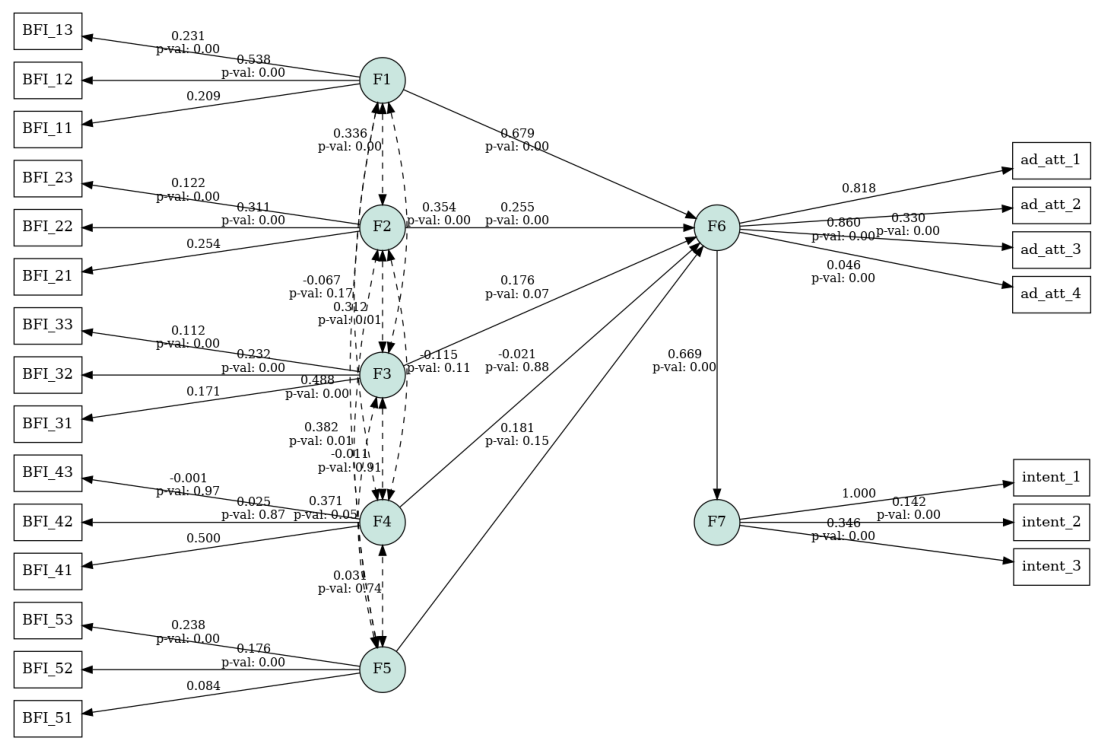

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_png(path, width=12, height=8):
    # Set canvas size
    plt.figure(figsize=(width, height))
    # Read image
    img = mpimg.imread(path)
    # Show image
    plt.imshow(img)
    plt.axis("off")  # hide axes
    plt.show()

# Example: display a large figure
show_png("./sem_outputs/sem_model_standardized_aligned.png", width=14, height=10)


In [45]:
1

1